### Optimización de carteras con algorítmo genético.

## Configuración del problema:
Se encuentra en el archivo `main/config/problem_config.py`

Allí se pueden encontrar valores de configuración tales como el máximo número de generaciones, número de individuos, etc.

## Individuos:
Son representados mediante la clase Individual disponible en: `main/individual/individual.py`

## Tiempo de ejecución aproximado: 5 minutos.

## Requisitos:

**1. Frontera eficiente: en la raíz del entregable llamada frontera_eficiente.png**

**2. Tiempo de ejecución menor a 10 minutos**


## Preguntas a resolver:

**1. Funcion objetivo a resolver:**
En mi caso la función objetivo es el ratio de sharpe, al tratarse de un problema multi objetivo (maximizar retorno y minimizar riesgo) se puede utilizar como función objetivo el ratio de sharpe.

**2. Los inversores (cromosomas) deben poder generar carteras con un número variable de activos. Estableceremos el mínimo en 1 activo y 20 en el máximo. El número de activos debe poder modificarse entre generaciones, sin caer en extremos (que siempre salgan carteras de 1 activo o de 20). Debemos pensar un sistema coherente, para resolver este punto.**

Las carteras son representadas mediante la clase Individual y una población de individuos representa un conjunto de carteras o soluciones. Cada cartera del individuo se genera mediante dos vectores de longitud variable entre 1 y 20, uno contiene índices de activos en el universo de activos y el otro contiene los pesos de dichos activos.

**3. ¿Cómo va a heredar el hijo la información genética de los padres? Aquí tenemos un triple problema a resolver (argumenta la solución a estos tres puntos con todo lujo de detalles)**

> **a. ¿Cuál es el número de activos que hereda un hijo de dos padres? Si un padre tiene 5 activos y el otro 7 (distintos entre sí), ¿cuántos activos tendrá el hijo? Debemos pensar en el punto primero. El hijo no puede tener un número de activos creciente en cada generación. El sistema tiene que ser dinámico, creciente y decreciente, respetando los límites de 1 y 20.**

>Entre generaciones el número de activos de cada individuo será variable, para ello trabajaré en módulo 20 de tal forma que 20 será el número máximo de activos que puede tener un individuo mientras que el mínimo será 1. Mi método de cruce evita que las carteras resultantes caigan en mínimos o máximos (1 o 20 activos) constantemente. Como ejemplo, si dos padres tienen 14 y 17 activos respectivamente al trabajar en módulo 20 su descendencia tendrá 11 activos mientras que si dos padres tienen 2 y 3 activos respectivamente su descendencia tendrá 5 de esos activos. La descendencia también hereda los pesos de los activos de los padres de esta forma me aseguro de que nunca sumen más de 1. Si dos padres tienen el mismo activo y este ha sido seleccionado para la descendencia, este activo no se hereda dos veces, sino que se suman los pesos y se hereda una vez solo, de esta forma evitamos que la decendencia tenga varios activos repetidos.

>**b.	¿Qué porcentaje de inversión hereda cada activo para que sume 100%? Debemos permitir la construcción de carteras donde unos pocos activos (1 o 2) se lleven un porcentaje muy elevado del capital disponible, para explorar todas las soluciones. Reescalar los pesos no es una solución aceptable.**

> Cuando un descendiente hereda los activos de los padres, hereda también los pesos siguiendo la siguiente ecuación:
> 
> Descendiente A = α ∗ Padre1 + (1 −α) ∗ Padre2
> 
> Descendiente B = (1 −α) ∗ Padre1 + α ∗ Padre2
> 
> Donde α es un número aleatorio entre 0 y 1.
> 
> De esta manera hay individuos que pueden tener pocos activos con gran porcentaje de capital acumulado.
>
> Esta función puede consultarse en: `main/tools/toolbox.arithmetic_roulette_crossover`


>**c.	La evolución, en este problema, no puede limitarse a selección y cruzamiento o caeremos rápidamente en un mínimo local. Debemos encontrar un sistema que equilibre la selección con la exploración, si queremos encontrar la cartera óptima. ¿Qué se te ocurre?**
>
> Efectivamente si nos limitamos a selección y cruce caeremos en un mínimo local, ya que no estamos añadiendo diversidad a nuestras poblaciones. Esto hace que nuestro problema se centre en obtener una alta explotación dejando de lado a la exploración. Para solventar esto añado diversidad en dos puntos, la selección y la mutación. En la mutación selecciono un número aleatorio de activos del individuo y los sustituyo por el mismo número de activos del universo de activos de tal forma que el individuo mutado siempre tiene el mismo número de activos y añado diversidad a la población. La probabilidad de mutación será variable en cada generación de tal forma que en unas generaciones se premiará la exploración mientras que otras se centrarán en la explotación del subespacio de soluciones actual. Si los individuos mutados no tienen un mejor grado de adaptación que el mejor individuo, son descartados.
>
> La función de mutación puede consultarse en: `main/tools/toolbox.mutation_stocks_fitness_driven`

**4. ¿Cómo vas a realizar el reemplazo generacional?**
> Se utilizará selección proporcional por ranking con elitismo y reemplazo migratorio.
> Este tipo de selección asigna una probabilidad a cada individuo de ser seleccionado en función de su función fitness, esto permite que los individuos mejor adaptados tengas más posibilidades de ser seleccionados y por tanto estén más presentes en la siguiente generación mientras que los individuos peor adaptados tienen menos posibilidades de ser seleccionados, por otro lado, al ser elite driven, escoge al n% mejor adaptado (10% en mi solución) y los añade a la siguiente generación para asegurar que los mejores estarán en la siguiente generación. De las plazas restantes otro porcentaje se asigna a reemplazo migratorio, donde nuevos individuos son incorporados a la selección favoreciendo así una mayor diversidad y por tanto mayor exploración.
> En mi solucion la selección se compone de:
> 
> Un 10% de plazas reservadas a los mejores individuos.
>
> Un 20% de plazas reservadas a individuos rankeados por fitness.
>
> Un 70% de plazas reservadas a nuevos individuos.

> Esta función puede consultarse en: `main/tools/toolbox.selection_rank_with_population_replacement_elite`

**5. Condición de parada**
Se ha definido como condición de parada alcanzar el máximo de generaciones definidas o encontrar una solución lo suficientemente buena para nuestro problema. Recordemos que los algoritmos genéticos no buscan encontrar una solución óptima, buscan encontrar una solución lo suficientemente buena en un tiempo aceptable.


In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import random

from main.config.problem_config import (
    CROSSOVER_PROBABILITY,
    MAX_GENERATIONS,
    POPULATION_SIZE,
    ELITE_SIZE,
    MIGRATORY_FACTOR,
    ACCEPTABLE_RETURN,
    ACCEPTABLE_RISK
)
from main.individual.individual import Individual
from main.tools.toolbox import (
    arithmetic_roulette_crossover,
    crossover_operation,
    mutation_operation,
    mutation_stocks_fitness_driven,
    plot_stats,
    selection_rank_with_population_replacement_elite,
    stats,
)

In [40]:
CROSSOVER_METHOD = arithmetic_roulette_crossover
MUTATION_METHOD = mutation_stocks_fitness_driven

In [41]:
universo = pd.read_csv("data/all_funds_universe.csv")
universo.drop(universo.std()[(universo.std() < 0.1)].index, axis=1, inplace=True)
Individual.set_stock_universe(universe=universo)

historical_inds = []
first_population = [Individual.create_random() for _ in range(POPULATION_SIZE)]
historical_inds.extend(first_population)
population = first_population.copy()

fitness_list = list(map(lambda x: x.get_sharpe(), population))
fit_avg = [sum(fitness_list) / len(population)]
fit_best = [max(fitness_list)]
fit_best_ever = [max(fitness_list + fit_best)]

best_ind = max(population, key=lambda ind: ind.get_sharpe())

generation = 0
expected_ret = 0
risk = 1

/tmp/ipykernel_931818/677347695.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  universo.drop(universo.std()[(universo.std() < 0.1)].index, axis=1, inplace=True)


In [42]:
while (expected_ret < ACCEPTABLE_RETURN and risk > ACCEPTABLE_RISK) or generation < MAX_GENERATIONS:
    mut_prob = random.random()

    offspring = selection_rank_with_population_replacement_elite(population, elite_size=ELITE_SIZE, new_pop=MIGRATORY_FACTOR)

    crossed_offspring = crossover_operation(population=offspring, method=CROSSOVER_METHOD, prob=CROSSOVER_PROBABILITY)
    mutated_offspring = mutation_operation(population=crossed_offspring, method=MUTATION_METHOD, prob=mut_prob)

    population = crossed_offspring.copy()
    historical_inds.extend(population)

    best_ind, fit_avg, fit_best, fit_best_ever = stats(population, best_ind, fit_avg, fit_best, fit_best_ever)
    expected_ret = best_ind.expected_return()
    risk = best_ind.risk()
    
    generation += 1
    print(f"GENERATION: {generation} BEST: {best_ind.get_sharpe()}")

GENERATION: 1 BEST: 0.16543119223990713
GENERATION: 2 BEST: 0.24117079103107192
GENERATION: 3 BEST: 0.2574553473161267
GENERATION: 4 BEST: 0.2574553473161267
GENERATION: 5 BEST: 0.5103141435209133
GENERATION: 6 BEST: 0.5103141435209133
GENERATION: 7 BEST: 0.5103141435209133
GENERATION: 8 BEST: 0.5103141435209133
GENERATION: 9 BEST: 0.5498610166377691
GENERATION: 10 BEST: 0.5498610166377691
GENERATION: 11 BEST: 0.5498610166377691
GENERATION: 12 BEST: 0.5649925945765188
GENERATION: 13 BEST: 0.5649925945765188
GENERATION: 14 BEST: 0.5649925945765188
GENERATION: 15 BEST: 0.5649925945765188
GENERATION: 16 BEST: 0.5649925945765188
GENERATION: 17 BEST: 0.5649925945765188
GENERATION: 18 BEST: 0.5649925945765188
GENERATION: 19 BEST: 0.5817403128020157
GENERATION: 20 BEST: 0.5845747016698954
GENERATION: 21 BEST: 0.5845747016698954
GENERATION: 22 BEST: 0.5845747016698954
GENERATION: 23 BEST: 0.5845747016698954
GENERATION: 24 BEST: 0.5845747016698954
GENERATION: 25 BEST: 0.6333835139705676
GENERAT

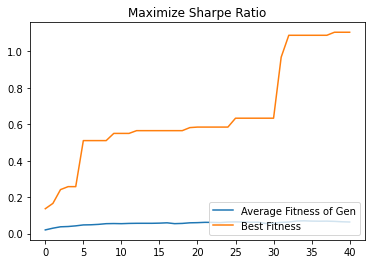

In [43]:
plot_stats(fit_avg, fit_best_ever, "Maximize Sharpe Ratio")

In [44]:
best_ret = max(historical_inds, key=lambda ind: ind.expected_return())
low_risk = min(historical_inds, key=lambda ind: ind.risk())

### BEST RETURN PORTFOLIO:

In [45]:
best_ret.expected_return()

0.02171460758501857

In [46]:
best_ret.universe.columns[best_ret.portfolio_idx].values.reshape(1, len(best_ret.portfolio_idx))

array([['LU2191963938']], dtype=object)

In [47]:
best_ret.portfolio_weights.reshape(1, len(best_ret.portfolio_weights))

array([[1]])

### BEST SHARPE PORTFOLIO:

In [48]:
best_ind.get_sharpe()

1.1055302642429092

In [49]:
best_ind.universe.columns[best_ind.portfolio_idx]

Index(['LU1931926452', 'LU1504938546', 'LU1775947846', 'GB0007809600',
       'LU1016219955', 'LU1799130890', 'IE0031294303', 'IE00BYX7RF96'],
      dtype='object')

In [50]:
best_ind.portfolio_weights.reshape(1, len(best_ind.portfolio_weights))

array([[1.60275949e-02, 2.17445641e-05, 1.30119534e-03, 7.67485960e-06,
        5.97603804e-03, 3.20821999e-01, 6.55146631e-01, 6.97122501e-04]])

### LOWEST RISK PORFOLIO:

In [51]:
low_risk.risk()

1.1678043510433323e-05

In [52]:
low_risk.universe.columns[low_risk.portfolio_idx].values.reshape(1, len(low_risk.portfolio_idx))

array([['FR0011408798']], dtype=object)

In [53]:
low_risk.portfolio_weights.reshape(1, len(low_risk.portfolio_weights))

array([[1.]])

### EFFICIENT FRONTIER:

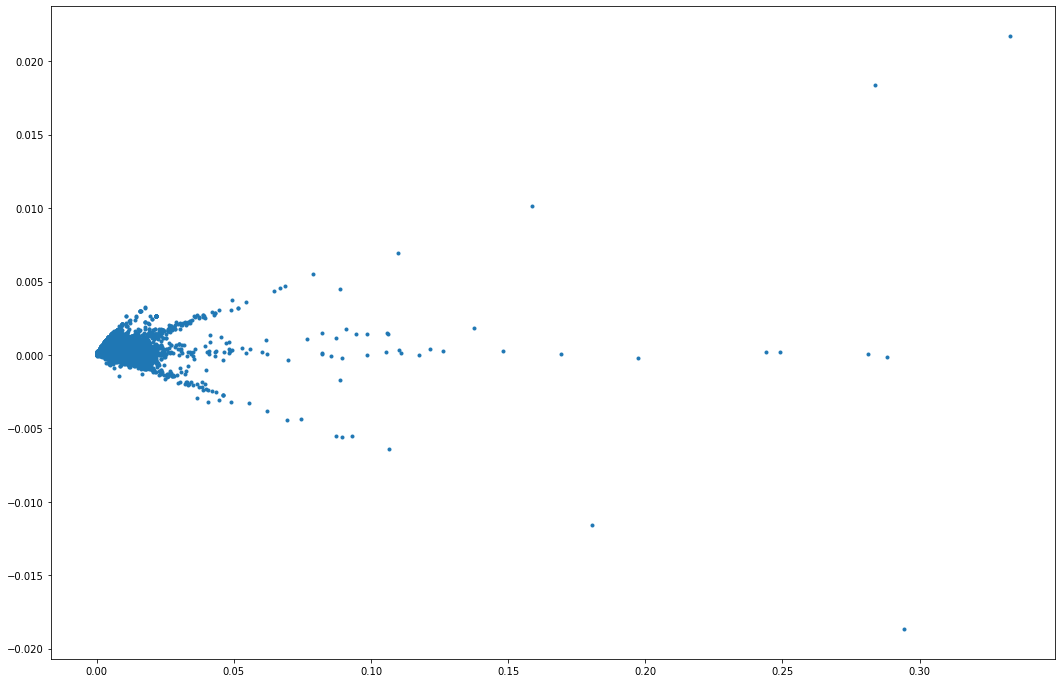

In [54]:
ret = list(map(lambda x: x.expected_return(), historical_inds))
risk = list(map(lambda x: x.risk(), historical_inds))

fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(risk, ret, ".")
plt.show()